# 1 单层神经网络

In [63]:
import torch
import numpy as np

定义特征张量X，w，andgate

## 1.1 新手常见问题

避坑指南：  
坑一：静态数据类型，预先设置好类型  
坑二：标签二维向量定义，注意即可不再展开说明  
坑三：精度问题，用float64，但计算存储会有问题

In [34]:
X = torch.tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]]
                 # 如果不标注类型就是long，相乘会报错
                 , dtype = torch.float32
                )
w = torch.tensor([-0.2,0.15,0.15], dtype = torch.float32)
# 有时候pytorch的函数不接受一维向量，所以为了保险起见最好变成二维的tensor
z = torch.tensor([[-0.2],[-0.05], [-0.05],[0.1]], dtype = torch.float32)

In [35]:
X.shape, w.shape, z.shape

(torch.Size([4, 3]), torch.Size([3]), torch.Size([4, 1]))

### 1.1.1 静态数据类型

In [36]:
def linearR(X, w):
    #矩阵与向量相乘，使用函数torch.mv，向量必须写作第二个参数。
    z_hat = torch.mv(X, w)
    return z_hat

In [43]:
z_hat = linearR(X, w)
z_hat

tensor([-0.2000, -0.0500, -0.0500,  0.1000])

不推荐使用下面Tensor这种无脑定义float32的方法，因为pytorch静态性计算的时候会一个一个判断类型，向量很大的时候就判断的挺累，所以不如一开始指定

In [38]:
torch.Tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])

In [39]:
torch.Tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]]).dtype

torch.float32

In [40]:
z

tensor([[-0.2000],
        [-0.0500],
        [-0.0500],
        [ 0.1000]])

### 1.1.2 精度问题

让其回到4，然后和预测值对比

In [41]:
z = z.view([4])

In [42]:
z.shape

torch.Size([4])

In [46]:
z_hat.dtype, z.dtype

(torch.float32, torch.float32)

发现只有1个True其他是False，这里不是数据类型带来的问题，而是精度问题在，这里设置精度

In [47]:
z_hat == z

tensor([ True, False, False, False])

In [52]:
SSE = sum((z_hat - z)**2)
SSE

tensor(8.3267e-17)

In [56]:
# float32由于只保留32位，所以精确性会有一些问题
# torch.mv这个函数在进行计算的时候，内部计算时会出现一些很微小的精度问题
torch.set_printoptions(precision=30)

In [57]:
z_hat

tensor([-0.200000002980232238769531250000, -0.049999997019767761230468750000,
        -0.049999997019767761230468750000,  0.100000008940696716308593750000])

In [58]:
z

tensor([-0.200000002980232238769531250000, -0.050000000745058059692382812500,
        -0.050000000745058059692382812500,  0.100000001490116119384765625000])

In [64]:
np.prod([300,68,64,64])

83558400

In [59]:
preds = torch.ones(300,68,64,64) * 0.1
preds.sum() * 10

tensor(83558432.)

In [65]:
preds = torch.ones(300,68,64,64,dtype = torch.float64) *0.1
preds.sum() * 10

tensor(83558400.000000059604644775390625000000, dtype=torch.float64)

In [67]:
torch.allclose(z_hat, z, rtol=1e-05, atol=1e-08)

True

## 1.2 单层正向传播

In [76]:
import torch
torch.set_printoptions(precision=4)

In [73]:
X = torch.tensor([[0,0],[1,0],[0,1],[1,1]], dtype = torch.float32)
X.shape

torch.Size([4, 2])

In [74]:
output = torch.nn.Linear(2,1)
z_hat = output(X)

- nn.Linear是一个类，在这里代表了输出层，所以我使用output作为变量名，output = 的这一行相当于是类的实例化过程
- 实例化的时候，nn.Linear需要输入两个参数，分别是（上一层的神经元个数，这一层的神经元个数）。上一层是输入层，因此神经元个数由特征的个数决定（2个）。这一层是输出层，作为回归神经网络，输出层只有一个神经元。因此nn.Linear中输入的是（2，1）。
- 我只定义了X，没有定义w和b。所有nn.Module的子类，形如nn.XXX的层，都会在实例化的同时随机生成w和b的初始值。所以实例化之后，我们就可以调用以下属性来查看生成的w和b：

In [77]:
output.weight 

Parameter containing:
tensor([[-0.0169, -0.2407]], requires_grad=True)

In [78]:
output.bias

Parameter containing:
tensor([0.6472], requires_grad=True)

其中，w是必然会生成的，b是我们可以控制是否要生成的。在nn.Linear类中，有参数bias，默认bias = True。如果我们希望不拟合常量b，在实例化时将参数bias设置为False即可：

In [79]:
output = torch.nn.Linear(2,1,bias=False)
#再次调用属性weight和bias
output.weight
output.bias

由于w和b是随机生成的，所以同样的代码多次运行后的结果是不一致的。如果我们希望控制随机性，则可以使用torch中的random类。如下所示：

In [83]:
torch.random.manual_seed(420) #人为设置随机数种子
output = torch.nn.Linear(2,1)
z_hat = output(X)
z_hat

tensor([[0.6730],
        [1.1048],
        [0.2473],
        [0.6792]], grad_fn=<AddmmBackward>)

- 由于不需要定义常量b，因此在特征张量中，也不需要留出与常数项相乘的x0那一列。在输入数据时，我们只输入了两个特征x1与x2
- 输入层只有一层，并且输入层的结构（神经元的个数）由输入的特征张量 决定，因此在PyTorch中构筑神经网络时，不需要定义输入层
- 实例化之后，将特征张量输入到实例化后的类中，即可得出输出层的输出结果。

In [84]:
z_hat.shape

torch.Size([4, 1])

## 1.3 单层二分类

In [90]:
import torch

In [91]:
X = torch.tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]], dtype = torch.float32)

In [107]:
# 标签，分类问题的标签是整型，虽然这样定义了float但本质还是整数，对比不会有精度问题
andgate = torch.tensor([[0],[0],[0],[1]], dtype = torch.float32)

In [117]:
w = torch.tensor([-0.2, 0.15,0.15],dtype =torch.float32)

In [118]:
def LogisticR(X,w):
    z_hat = torch.mv(X,w)
    sigma = 1/(1+torch.exp(-z_hat))
    #sigma = torch.sigmoid(zhat)
    andhat = torch.tensor([int(x) for x in sigma >= 0.5], dtype = torch.float32)
    return sigma, andhat

In [119]:
sigma, andhat = LogisticR(X,w)

In [120]:
sigma

tensor([0.4502, 0.4875, 0.4875, 0.5250])

In [121]:
andhat

tensor([0., 0., 0., 1.])

最后得到的都是0和1，虽然是andhat的数据格式是float32，但本质上数还是整数，不存在精度问题

In [122]:
andgate.view([4]) == andhat

tensor([True, True, True, True])

## 1.4 常见分类函数

符号函数sign，ReLU，Tanh

In [123]:
import torch
X = torch.tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]], dtype = torch.float32)
andgate = torch.tensor([[0],[0],[0],[1]], dtype = torch.float32)
w = torch.tensor([-0.2,0.15, 0.15], dtype = torch.float32)
def LinearRwithsign(X,w):
    zhat = torch.mv(X,w)
    andhat = torch.tensor([int(x) for x in zhat >= 0], dtype = torch.float32)
    return zhat, andhat
zhat, andhat = LinearRwithsign(X,w)
zhat, andhat

(tensor([-0.2000, -0.0500, -0.0500,  0.1000]), tensor([0., 0., 0., 1.]))

In [124]:
import torch
from torch.nn import functional as F
X = torch.tensor([[0,0],[1,0],[0,1],[1,1]], dtype = torch.float32)
torch.random.manual_seed(420) #人为设置随机数种子
dense = torch.nn.Linear(2,1)
zhat = dense(X)
sigma = F.sigmoid(zhat)
y = [int(x) for x in sigma > 0.5]

F:\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [125]:
torch.random.manual_seed(420) #人为设置随机数种子
dense = torch.nn.Linear(2,1)
zhat = dense(X)
#符号函数sign
torch.sign(zhat)

tensor([[1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SignBackward>)

In [126]:
#ReLU
F.relu(zhat)

tensor([[0.6730],
        [1.1048],
        [0.2473],
        [0.6792]], grad_fn=<ReluBackward0>)

In [127]:
#tanh
torch.tanh(zhat)

tensor([[0.5869],
        [0.8022],
        [0.2424],
        [0.5910]], grad_fn=<TanhBackward>)

## 1.5 多分类Softmax

### 1.5.1 Softmax溢出现象

用torch自带的softmax不然可能会溢出无法判断

In [131]:
#对于单一样本，假定一组巨大的z
z = torch.tensor([1010,1000,990], dtype=torch.float32)
torch.exp(z) / torch.sum(torch.exp(z)) # softmax函数的运算

tensor([nan, nan, nan])

In [132]:
torch.softmax(z,0)

tensor([9.9995e-01, 4.5398e-05, 2.0611e-09])

In [135]:
#假设三个输出层神经元得到的z分别是10，9，5
z = torch.tensor([10,9,5], dtype=torch.float32)
torch.exp(z) / torch.sum(torch.exp(z)) # softmax函数的运算

tensor([0.7275, 0.2676, 0.0049])

In [136]:
z = torch.tensor([10,9,5], dtype=torch.float32)
torch.softmax(z,0)

tensor([0.7275, 0.2676, 0.0049])

可以上下乘上C，然后让$e^{log_C}$中的$log_C$接近下面$e^{z_i}$最大的那个$z_i$

In [151]:
import numpy as np
z = np.array([1010,1000,990])
#定义softmax函数
def softmax(z):
    c = np.max(z)
    exp_z = np.exp(z - c) #溢出对策
    sum_exp_z = np.sum(exp_z)
    o = exp_z / sum_exp_z
    return o
#导入刚才定义的z
softmax(z)

array([9.99954600e-01, 4.53978686e-05, 2.06106005e-09])

In [163]:
sum(softmax(z))

1.0

### 1.5.2 多维Softmax

看到下面计算的结果，你明白这个维度的含义了吗？实际上softmax函数在实际中应用不多，但是只要用到，新手就一定会被绕进dim参数的选项中去，因此我们在这里特此说明。

In [144]:
s = torch.tensor([[[1,2],[3,4],[5,6]],[[5,6],[7,8],[9,10]]],
dtype=torch.float32)
s.ndim, s.shape

(3, torch.Size([2, 3, 2]))

In [145]:
X = torch.tensor([[0,0],[1,0],[0,1],[1,1]], dtype = torch.float32)

In [147]:
#在整个张量中，有2个张量，一个二维张量就是一类
torch.softmax(s,dim=0)

tensor([[[0.0180, 0.0180],
         [0.0180, 0.0180],
         [0.0180, 0.0180]],

        [[0.9820, 0.9820],
         [0.9820, 0.9820],
         [0.9820, 0.9820]]])

In [148]:
#在一个二维张量中，有3行数据，每一行是一种类别
torch.softmax(s,dim=1)

tensor([[[0.0159, 0.0159],
         [0.1173, 0.1173],
         [0.8668, 0.8668]],

        [[0.0159, 0.0159],
         [0.1173, 0.1173],
         [0.8668, 0.8668]]])

In [149]:
#在每一行中，有4个数据，每个数据是一种类别
torch.softmax(s,dim=2)

tensor([[[0.2689, 0.7311],
         [0.2689, 0.7311],
         [0.2689, 0.7311]],

        [[0.2689, 0.7311],
         [0.2689, 0.7311],
         [0.2689, 0.7311]]])

# 2 多层神经网络

## 2.1 异或门问题

这里异或门只是说明神经网络一定要有隐藏层，不需要特别仔细研究

### 2.1.1 与门

In [164]:
import torch
X = torch.tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]], dtype = torch.float32)
andgate = torch.tensor([0,0,0,1], dtype = torch.float32)
#定义w
w = torch.tensor([-0.2,0.15,0.15], dtype = torch.float32)

In [170]:
def LogisticR(X,w):
    zhat = torch.mv(X,w) #首先执行线性回归的过程，依然是mv函数，让矩阵与向量相乘得到z
    sigma = torch.sigmoid(zhat) #执行sigmoid函数，你可以调用torch中的sigmoid函数，也可以自己用torch.exp来写
    andhat = torch.tensor([int(x) for x in sigma >= 0.5], dtype = torch.float32) #设置阈值为0.5, 使用列表推导式将值转化为0和1
    return sigma, andhat

In [171]:
sigma, andhat = LogisticR(X,w)

In [172]:
sigma, andhat

(tensor([0.4502, 0.4875, 0.4875, 0.5250]), tensor([0., 0., 0., 1.]))

In [173]:
andgate == andhat

tensor([True, True, True, True])

可以对与门进行可视化

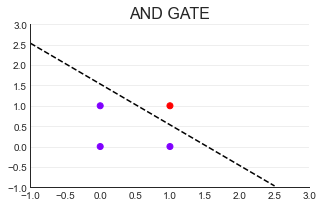

In [180]:
#设置一个画布
plt.style.use('seaborn-whitegrid') #设置图像的风格
sns.set_style("white")
plt.figure(figsize=(5,3)) #设置画布大小
plt.scatter(X[:,1],X[:,2] #散点图的横坐标和纵坐标
            ,c=andgate #颜色=真实标签的类别
            ,cmap="rainbow") #绘制散点图
plt.xlim(-1,3) #设置横纵坐标尺寸
plt.ylim(-1,3)
plt.title("AND GATE",fontsize=16) #设置图像标题
plt.grid(alpha=.4,axis="y") #显示背景中的网格
plt.gca().spines["top"].set_alpha(.0) #让上方和右侧的坐标轴被隐藏
plt.gca().spines["right"].set_alpha(.0);
import numpy as np
x = np.arange(-1,3,0.5)
plt.plot(x,(0.23-0.15*x)/0.15 #这里是从直线的表达式变型出的x2 = 的式子
         ,color="k",linestyle="--");

In [181]:
import torch
X = torch.tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]], dtype = torch.float32)
andgate = torch.tensor([0,0,0,1], dtype = torch.float32)

In [208]:
def AND(X):
    w = torch.tensor([-0.2,0.15, 0.15], dtype = torch.float32)
    zhat = torch.mv(X,w)
    andhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return andhat

In [183]:
andhat = AND(X) #使用直线来划分两个类别的点，也就是阶跃函数划分与门数据的函数

In [184]:
andhat

tensor([0., 0., 0., 1.])

### 2.1.2 或门

In [185]:
import torch

In [186]:
X = torch.tensor([[1,0,0],[1,1,0],[1,0,1],[1,1,1]],dtype=torch.float32)

In [187]:
orgate = torch.tensor([0,1,1,1],dtype=torch.float32)

In [209]:
def OR(X):
    w = torch.tensor([-0.08, 0.15,0.15], dtype = torch.float32)
    zhat = torch.mv(X,w)
    yhat = torch.tensor([int(x) for x in zhat > 0], dtype=torch.float32)
    return yhat

In [190]:
OR(X)

tensor([0., 1., 1., 1.])

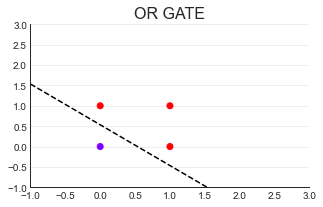

In [189]:
#绘制直线划分散点的图像
x = np.arange(-1,3,0.5)
plt.figure(figsize=(5,3))
plt.title("OR GATE",fontsize=16)
plt.scatter(X[:,1],X[:,2],c=orgate,cmap="rainbow") 
plt.plot(x,(0.08-0.15*x)/0.15,color="k",linestyle="--") 
plt.xlim(-1,3) 
plt.ylim(-1,3)
plt.grid(alpha=.4,axis="y") 
plt.gca().spines["top"].set_alpha(.0) 
plt.gca().spines["right"].set_alpha(.0)

### 2.1.3 非与门

In [210]:
#非与门、非与门的图像
nandgate = torch.tensor([1,1,1,0], dtype = torch.float32)

def NAND(X):
    w = torch.tensor([0.23,-0.15,-0.15], dtype = torch.float32) #和与门、或门都不同的权重
    zhat = torch.mv(X,w)
    yhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return yhat

In [192]:
NAND(X)

tensor([1., 1., 1., 0.])

In [193]:
nandgate

tensor([1., 1., 1., 0.])

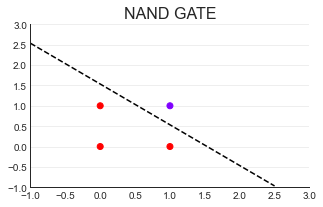

In [194]:
#图像
x = np.arange(-1,3,0.5)
plt.figure(figsize=(5,3))
plt.title("NAND GATE",fontsize=16)
plt.scatter(X[:,1],X[:,2],c=nandgate,cmap="rainbow") 
plt.plot(x,(0.23-0.15*x)/0.15,color="k",linestyle="--") 
plt.xlim(-1,3) 
plt.ylim(-1,3)
plt.grid(alpha=.4,axis="y") 
plt.gca().spines["top"].set_alpha(.0) 
plt.gca().spines["right"].set_alpha(.0)

### 2.1.4 异或门

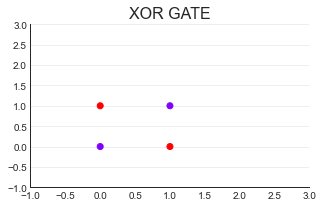

In [195]:
xorgate = torch.tensor([0,1,1,0], dtype = torch.float32)

plt.figure(figsize=(5,3))
plt.title("XOR GATE",fontsize=16)
plt.scatter(X[:,1],X[:,2],c=xorgate,cmap="rainbow")
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.grid(alpha=.4,axis="y")
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)

### 2.1.5 增加中间层

![](./pics/单层多层神经网络/中间层.png)

In [211]:
X

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])

In [212]:
sigma_nand = NAND(X) #y_nand

In [213]:
sigma_or = OR(X)

In [214]:
x0 = torch.tensor([1,1,1,1], dtype=torch.float32)

In [215]:
input_2 = torch.cat((x0.view(4,1),sigma_nand.view(4,1),sigma_or.view(4,1)),dim=1)

In [216]:
AND(input_2)

tensor([0., 1., 1., 0.])

## 2.2 激活函数

### 2.2.1 深层和激活函数

很明显，此时XOR函数的预测结果与真实的xorgate不一致。当隐藏层的激活函数是恒等函数或不存在时，叠加层并不能够解决XOR这样的非线性问题。从数学上来看，这也非常容易理解。

In [218]:
#回忆一下XOR数据的真实标签
xorgate = torch.tensor([0,1,1,0],dtype=torch.float32)
    
def AND(X):
    w = torch.tensor([-0.2,0.15, 0.15], dtype = torch.float32)
    zhat = torch.mv(X,w)
    #下面这一行就是阶跃函数的表达式，注意AND函数是在输出层，所以保留输出层的阶跃函数g(z)
    andhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return andhat

def OR(X):
    w = torch.tensor([-0.08,0.15,0.15], dtype = torch.float32) #在这里我修改了b的数值
    zhat = torch.mv(X,w)
    #注释掉阶跃函数，相当于h(z)是恒等函数
    #yhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return zhat

def NAND(X):
    w = torch.tensor([0.23,-0.15,-0.15], dtype = torch.float32) 
    zhat = torch.mv(X,w)
    #注释掉阶跃函数，相当于h(z)是恒等函数
    #yhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return zhat

def XOR(X):
    #输入值：
    input_1 = X
    #中间层：
    sigma_nand = NAND(input_1)
    sigma_or = OR(input_1)
    x0 = torch.tensor([[1],[1],[1],[1]],dtype=torch.float32)
    #输出层：
    input_2 = torch.cat((x0,sigma_nand.view(4,1),sigma_or.view(4,1)),dim=1)
    y_and = AND(input_2)
    #print("NANE:",y_nand)
    #print("OR:",y_or)
    return y_and

In [219]:
XOR(X)

tensor([0., 0., 0., 0.])

In [220]:
xorgate

tensor([0., 1., 1., 0.])

### 2.2.2 找寻激活函数

如果换用sigmoid激活函数，发现也没法解决，所以需要搭配合适的激活函数！

In [221]:
def AND(X):
    w = torch.tensor([-0.2,0.15, 0.15], dtype = torch.float32)
    zhat = torch.mv(X,w)
    #下面这一行就是阶跃函数的表达式，注意AND函数是在输出层，所以保留输出层的阶跃函数g(z)
    andhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return andhat

In [222]:
def OR(X):
    w = torch.tensor([-0.08,0.15,0.15], dtype = torch.float32) #在这里我修改了b的数值
    zhat = torch.mv(X,w)
    #h(z), 使用sigmoid函数
    sigma = torch.sigmoid(zhat)
    return sigma

In [223]:
def NAND(X):
    w = torch.tensor([0.23,-0.15,-0.15], dtype = torch.float32) 
    zhat = torch.mv(X,w)
    #h(z), 使用sigmoid函数
    sigma = torch.sigmoid(zhat)
    return sigma

In [224]:
def XOR(X):
    #输入值：
    input_1 = X
    #中间层：
    sigma_nand = NAND(input_1)
    sigma_or = OR(input_1)
    x0 = torch.tensor([[1],[1],[1],[1]],dtype=torch.float32)
    #输出层：
    input_2 = torch.cat((x0,sigma_nand.view(4,1),sigma_or.view(4,1)),dim=1)
    y_and = AND(input_2)
    #print("NANE:",y_nand)
    #print("OR:",y_or)
    return y_and

In [225]:
XOR(X)

tensor([0., 0., 0., 0.])

In [226]:
xorgate

tensor([0., 1., 1., 0.])

发现只要隐藏层是阶跃函数XOR就一定有效，和输出层是什么函数无关

有十多种激活函数：https://en.wikipedia.org/wiki/Activation_function

In [228]:
#如果g(z)是sigmoid函数，而h(z)是阶跃函数
#输出层，以0.5为sigmoid的阈值
def AND(X):
    w = torch.tensor([-0.2,0.15, 0.15], dtype = torch.float32)
    zhat = torch.mv(X,w)
    sigma = torch.sigmoid(zhat)
    andhat = torch.tensor([int(x) for x in sigma >= 0.5],dtype=torch.float32)
    return andhat
#隐藏层，OR与NAND都使用阶跃函数作为h(z)
def OR(X):
    w = torch.tensor([-0.08,0.15,0.15], dtype = torch.float32) #在这里我修改了b的数值
    zhat = torch.mv(X,w)
    yhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return yhat
def NAND(X):
    w = torch.tensor([0.23,-0.15,-0.15], dtype = torch.float32)
    zhat = torch.mv(X,w)
    yhat = torch.tensor([int(x) for x in zhat >= 0],dtype=torch.float32)
    return yhat
def XOR(X):
    #输入值：
    input_1 = X
    #中间层：
    sigma_nand = NAND(input_1)
    sigma_or = OR(input_1)
    x0 = torch.tensor([[1],[1],[1],[1]],dtype=torch.float32)
    #输出层：
    input_2 = torch.cat((x0,sigma_nand.view(4,1),sigma_or.view(4,1)),dim=1)
    y_and = AND(input_2)
    #print("NANE:",y_nand)
    #print("OR:",y_or)
    return y_and
XOR(X)

tensor([0., 1., 1., 0.])

## 2.3 多层神经网络正向传播

### 2.3.1 网络构建

In [229]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [230]:
#确定数据
torch.random.manual_seed(420)
X = torch.rand((500,20), dtype=torch.float32)
y = torch.randint(low=0,high=3,size=(500,1), dtype=torch.float32)

假设我们有500条数据，20个特征，标签为3分类。我们现在要实现一个三层神经网络，这个神经网络的架构如下：第一层有13个神经元，第二层有8个神经元，第三层是输出层。其中，第一层的激活函数是relu，第二层是sigmoid。

In [231]:
import torch.nn as nn

In [232]:
class Model(nn.Module):
    def __init__(self, in_fea=10, out_fea=2):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(in_fea, 13, bias=True)
        self.linear2 = nn.Linear(13, 8, bias=True)
        self.output = nn.Linear(8, out_fea, bias=True)
        
    def forward(self, x):
        z1= self.linear1(x)
        act1 = torch.relu(z1)
        z2 = self.linear2(act1) 
        act2 = torch.sigmoid(z2)
        z3 = self.output(act2)
        act3 = torch.softmax(z3, dim=1)
        return act3

In [236]:
X.shape[1], len(y.unique())

(20, 3)

In [235]:
input_ = X.shape[1]
output_ = len(y.unique())

In [238]:
#实例化神经网络
torch.random.manual_seed(420)
net = Model(in_fea=input_, out_fea = output_)

In [239]:
net.forward(X) #向前传播

tensor([[0.4140, 0.3496, 0.2365],
        [0.4210, 0.3454, 0.2336],
        [0.4011, 0.3635, 0.2355],
        ...,
        [0.4196, 0.3452, 0.2352],
        [0.4153, 0.3455, 0.2392],
        [0.4153, 0.3442, 0.2405]], grad_fn=<SoftmaxBackward>)

In [240]:
net(X)

tensor([[0.4140, 0.3496, 0.2365],
        [0.4210, 0.3454, 0.2336],
        [0.4011, 0.3635, 0.2355],
        ...,
        [0.4196, 0.3452, 0.2352],
        [0.4153, 0.3455, 0.2392],
        [0.4153, 0.3442, 0.2405]], grad_fn=<SoftmaxBackward>)

In [242]:
net.forward(X).shape #softamx最后输出的概率

torch.Size([500, 3])

In [250]:
net.linear1.weight.shape  # torch.Size([13, 20])
#w X(500,20) _> (20,500)
#w (13,20) * (20,500) -> (13,500)
net.linear2.weight.shape # torch.Size([8, 13])
#w (8, 13) * (13,500) -> (8,500)
net.output.weight.shape # torch.Size([3, 8])
# w(3, 8) * (8, 500) -> (3,500) -> (500,3)
net.linear1.bias.shape # torch.Size([13])

torch.Size([13])

### 2.3.2 父类研究

In [251]:
#建立一个父类
class FooParent(object):
    def __init__(self):
        self.parent = 'PARENT!!'
        print ('Running __init, I am parent')
    
    def bar(self,message):
        self.bar = "This is bar"
        print ("%s from Parent" % message)

In [252]:
FooParent() #父类实例化的瞬间，运行自己的__init__

Running __init, I am parent


In [253]:
FooParent().parent #父类运行自己的__init__中定义的属性

Running __init, I am parent


'PARENT!!'

In [254]:
#建立一个子类，并通过类名调用让子类继承父类的方法与属性
class FooChild(FooParent):
    def __init__(self):
        print ('Running __init__, I am child')

In [255]:
FooChild()

Running __init__, I am child


In [256]:
#查看子类是否继承了方法
FooChild().bar("HAHAHA")

Running __init__, I am child
HAHAHA from Parent


In [257]:
FooChild().parent #子类没有继承到父类的__init__中定义的属性

Running __init__, I am child


AttributeError: 'FooChild' object has no attribute 'parent'

为了让子类能够继承到父类的__init__函数中的内容，我们使用super函数

In [259]:
#新建一个子类，并使用super函数
class FooChild(FooParent):
    def __init__(self):
        super(FooChild,self).__init__()
        print ("I am running the __init__, I am child")

In [260]:
#再次调用parent属性
FooChild() #执行自己的init功能的同时，也执行了父类的init函数定义的功能

Running __init, I am parent
I am running the __init__, I am child


In [261]:
FooChild().parent

Running __init, I am parent
I am running the __init__, I am child


'PARENT!!'

### 2.3.3 nn.Module研究

不使用super函数无法构建神经网络

In [270]:
class Model(nn.Module):
    def __init__(self,in_features=10, out_features=2):
        """
        in_features: 输入该神经网络的特征数目（输入层上的神经元的数目）
        out_features：神经网络的输出的数目（输出层上的神经元的数目）
        """
#         super(Model,self).__init__()
        self.linear1 = nn.Linear(in_features,13,bias=True)
        self.linear2 = nn.Linear(13,8,bias=True)
        self.output = nn.Linear(8,out_features,bias=True)
    
Model()

AttributeError: cannot assign module before Module.__init__() call

In [271]:
class Model(nn.Module):
    def __init__(self,in_features=10, out_features=2):
        """
        in_features: 输入该神经网络的特征数目（输入层上的神经元的数目）
        out_features：神经网络的输出的数目（输出层上的神经元的数目）
        """
        super(Model,self).__init__()
        self.linear1 = nn.Linear(in_features,13,bias=True)
        self.linear2 = nn.Linear(13,8,bias=True)
        self.output = nn.Linear(8,out_features,bias=True)
    
    def forward(self,x): #神经网络的向前传播
        z1 = self.linear1(x)
        sigma1 = torch.relu(z1)
        z2 = self.linear2(sigma1)
        sigma2 = torch.sigmoid(z2)
        z3 = self.output(sigma2)
        sigma3 = F.softmax(z3,dim=1)
        return sigma3

In [273]:
net = Model()

继承了属性training，是否用于训练

In [275]:
net.training

True

继承了cuda和cpu方法

In [278]:
# net.cuda()
net.cpu()

Model(
  (linear1): Linear(in_features=10, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=2, bias=True)
)

继承了apply方法

In [282]:
# net.apply() #对__init__中的所有对象（全部层）都执行同样的操作
#比如，令所有线性层的初始权重w都为0
def initial_0(m):
    print(m)
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
        print(m.weight)

In [283]:
net.apply(fn=initial_0)

Linear(in_features=10, out_features=13, bias=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)
Linear(in_features=13, out_features=8, bias=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

Model(
  (linear1): Linear(in_features=10, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=2, bias=True)
)

In [284]:
net.linear1.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)

也继承了parameters方法

In [285]:
#一个特殊的方法
net.parameters() #一个迭代器，我们可以通过循环的方式查看里面究竟是什么内容

<generator object Module.parameters at 0x00000247E85C8CC8>

In [286]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([-0.0073, -0.2248, -0.2901,  0.0110,  0.0244,  0.2430,  0.3040, -0.2351,
        -0.0133,  0.3129, -0.0809,  0.1280,  0.2943], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.